In [1]:
import bioframe as bf
from datasets import load_dataset
from gpn.data import Genome, load_table, load_dataset_from_file_or_dir
from liftover import get_lifter
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import polars as pl
from scipy.spatial.distance import cdist
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif, SelectFdr
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
import torch
from tqdm import tqdm
import yaml

from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#dataset = "Height"
#dataset = "IBD"
#dataset = "merged"
dataset = "BMI"
V = pd.read_parquet(f"../../results/dataset/gwas_gokcen_{dataset}_matched_9_nonexonic/test.parquet")
V

,chrom,pos,ref,alt,MAF,PIP,label,consequence,tss_dist
0,1,31726197,G,C,0.38422,0.915444,True,dELS,21877
1,1,39498238,G,T,0.10360,0.000121,False,dELS,6601
2,1,74535042,G,C,0.40213,0.000457,False,dELS,22430
3,1,74536983,G,T,0.40240,0.000431,False,dELS,24371
4,1,77515414,C,A,0.40699,0.000218,False,dELS,16692
...,...,...,...,...,...,...,...,...,...
555,22,40654867,G,A,0.34416,0.000545,False,dELS,18147
556,22,40655320,C,T,0.34456,0.000263,False,dELS,18600
557,22,41280172,A,G,0.26908,0.000353,False,dELS,1448
558,22,41408712,G,A,0.29057,0.908133,True,dELS,25776


In [3]:
features_paths = [
    "GPN-MSA_InnerProducts",
    #"CADD",
    #"Borzoi_L2",
]
features = []
for features_path in features_paths:
    df = pd.read_parquet(f"../../results/dataset/gwas_gokcen_{dataset}_matched_9_nonexonic/features/{features_path}.parquet")
    df = df.fillna(df.mean())
    df.columns = [f"{features_path}_{col}" for col in df.columns]
    features += df.columns.tolist()
    V = pd.concat([V, df], axis=1)
features

['GPN-MSA_InnerProducts_embedding_0',
 'GPN-MSA_InnerProducts_embedding_1',
 'GPN-MSA_InnerProducts_embedding_2',
 'GPN-MSA_InnerProducts_embedding_3',
 'GPN-MSA_InnerProducts_embedding_4',
 'GPN-MSA_InnerProducts_embedding_5',
 'GPN-MSA_InnerProducts_embedding_6',
 'GPN-MSA_InnerProducts_embedding_7',
 'GPN-MSA_InnerProducts_embedding_8',
 'GPN-MSA_InnerProducts_embedding_9',
 'GPN-MSA_InnerProducts_embedding_10',
 'GPN-MSA_InnerProducts_embedding_11',
 'GPN-MSA_InnerProducts_embedding_12',
 'GPN-MSA_InnerProducts_embedding_13',
 'GPN-MSA_InnerProducts_embedding_14',
 'GPN-MSA_InnerProducts_embedding_15',
 'GPN-MSA_InnerProducts_embedding_16',
 'GPN-MSA_InnerProducts_embedding_17',
 'GPN-MSA_InnerProducts_embedding_18',
 'GPN-MSA_InnerProducts_embedding_19',
 'GPN-MSA_InnerProducts_embedding_20',
 'GPN-MSA_InnerProducts_embedding_21',
 'GPN-MSA_InnerProducts_embedding_22',
 'GPN-MSA_InnerProducts_embedding_23',
 'GPN-MSA_InnerProducts_embedding_24',
 'GPN-MSA_InnerProducts_embedding_2

In [4]:
res1 = []
for f in tqdm(features):
    res1.append([f, max(average_precision_score(V.label, V[f]), average_precision_score(V.label, -V[f]))])
res1 = pd.DataFrame(res1, columns=["feature", "AUPRC"]).sort_values("AUPRC", ascending=False)
res1

100%|████████████████████████████████████████████████████████| 768/768 [00:02<00:00, 315.73it/s]


,feature,AUPRC
586,GPN-MSA_InnerProducts_embedding_586,0.455135
559,GPN-MSA_InnerProducts_embedding_559,0.448580
8,GPN-MSA_InnerProducts_embedding_8,0.448457
671,GPN-MSA_InnerProducts_embedding_671,0.436073
425,GPN-MSA_InnerProducts_embedding_425,0.435772
...,...,...
143,GPN-MSA_InnerProducts_embedding_143,0.096671
225,GPN-MSA_InnerProducts_embedding_225,0.096520
209,GPN-MSA_InnerProducts_embedding_209,0.095726
206,GPN-MSA_InnerProducts_embedding_206,0.095407


In [7]:
pca = PCA(n_components=100, random_state=42).fit_transform(V[features])
res2 = []
for i in tqdm(range(pca.shape[1])):
    res2.append([f"PC{i}", max(average_precision_score(V.label, pca[:, i]), average_precision_score(V.label, -pca[:, i]))])
res2 = pd.DataFrame(res2, columns=["feature", "AUPRC"]).sort_values("AUPRC", ascending=False)
res2

  0%|                                                                   | 0/100 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 271.51it/s]


,feature,AUPRC
1,PC1,0.404476
4,PC4,0.276721
9,PC9,0.267656
19,PC19,0.239512
8,PC8,0.227592
...,...,...
5,PC5,0.106397
32,PC32,0.106120
85,PC85,0.105593
22,PC22,0.105069


In [14]:
X = V[features]
y = V.label

In [15]:
import networkx as nx

def find_correlated_groups(df, method="pearson", threshold=0.8):
    # Step 1: Compute the correlation matrix
    corr_matrix = df.corr(method=method).abs()  # Compute absolute correlations

    # Step 2: Create the adjacency matrix
    adj_matrix = (corr_matrix >= threshold).astype(int)
    
    # Step 3: Create a graph from the adjacency matrix
    G = nx.from_pandas_adjacency(adj_matrix)
    
    # Step 4: Find connected components
    connected_components = list(nx.connected_components(G))

    connected_components = [list(cc) for cc in connected_components]

    return connected_components

In [16]:
groups = find_correlated_groups(X, method="spearman", threshold=0.9)
len(groups)

536

In [17]:
len(groups[0])

1

In [18]:
groups[0]

['GPN-MSA_InnerProducts_embedding_0']

In [19]:
sum([len(group) for group in groups])

768

In [20]:
leads = []
for group in tqdm(groups):
    scores = [average_precision_score(y, X[feat]) for feat in group]
    i = np.argmax(scores)
    leads.append([group[i], scores[i]])
leads = pd.DataFrame(leads, columns=["feature", "score"]).sort_values("score", ascending=False).reset_index(drop=True)
leads

100%|████████████████████████████████████████████████████████| 536/536 [00:01<00:00, 447.62it/s]


,feature,score
0,GPN-MSA_InnerProducts_embedding_586,0.455135
1,GPN-MSA_InnerProducts_embedding_559,0.448580
2,GPN-MSA_InnerProducts_embedding_8,0.448457
3,GPN-MSA_InnerProducts_embedding_671,0.436073
4,GPN-MSA_InnerProducts_embedding_425,0.435772
...,...,...
531,GPN-MSA_InnerProducts_embedding_643,0.064150
532,GPN-MSA_InnerProducts_embedding_759,0.063229
533,GPN-MSA_InnerProducts_embedding_541,0.063055
534,GPN-MSA_InnerProducts_embedding_132,0.061888


/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:111

<Axes: ylabel='score'>

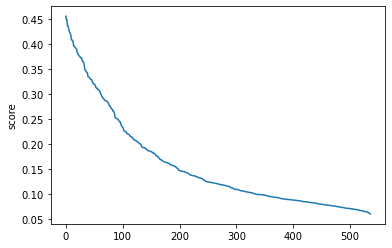

In [21]:
sns.lineplot(data=leads, x=leads.index, y="score")

In [ ]:
leads[leads.feature.str.startswith("Borzoi")]

In [ ]:
leads[leads.feature.str.startswith("CADD")]

In [ ]:
leads[leads.feature.str.startswith("GPN-MSA")]

In [22]:
lead_features = leads.feature.head(100)

In [ ]:
leads.head(10)

In [ ]:
corr = V[lead_features].corr(method="spearman").abs()
corr

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
# maybe should just use auprc
ranked_features = V[features].corrwith(V["label"], method="spearman").abs().sort_values(ascending=False)
ranked_features.head(10)

In [ ]:
#corr = V[["label"] + features].corr(method="spearman").abs()
corr = V[["label"] + ranked_features.head(50).index.values.tolist()].corr(method="spearman").abs()
corr

In [ ]:
from scipy.cluster.hierarchy import linkage, leaves_list

# need to do this better, label was clustering much better before

# perform hierarchical clustering
linkage_matrix = linkage(corr, method='average')
# get the reordered index
reordered_index = leaves_list(linkage_matrix)
# reorder the correlation matrix
corr = corr.iloc[reordered_index, reordered_index]
corr

In [ ]:
# TODO: should also show correlation with ref and alt (1-hot first, perhaps)
# only within GPN-MSA
# maybe 1-hot the multiplication of ref and alt (and dedup rc)

# TODO: try largest merged dataset
# TODO: filter to features with high correlation with label

label_idx = corr.columns.tolist().index('label')

idx = slice(None)
#idx = slice(45, 65)
#idx = slice(500, 700)
#idx = slice(label_idx-30, label_idx+30)

plt.figure(figsize=(20, 20))
sns.heatmap(
    corr.iloc[idx, idx],
    square=True,
    vmin=0, vmax=1,
)
#sns.clustermap(
    #corr.iloc[idx, idx],
    #corr,
    #cmap="coolwarm",
    #figsize=(30, 30),
#)
#plt.savefig("correlation.pdf", bbox_inches="tight")

In [23]:
#X = V[features]
X = V[lead_features]
y = V.label

mask_train = V.chrom.isin([str(i) for i in range(1, 23, 2)] + ["X"])
X_train = X[mask_train]
y_train = y[mask_train]
X_test = X[~mask_train]
y_test = y[~mask_train]
balanced = True

clf = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler', RobustScaler()),
    #('feature_selection', SelectKBest(score_func=f_classif, k=30)),
    #('feature_selection', SelectFdr(score_func=f_classif, alpha=0.05)),
    #('feature_selection', SelectFromModel(LogisticRegression(C=1e-1, penalty="l1", random_state=42, solver="saga"))),
    #('feature_selection', SelectFromModel(RandomForestClassifier(C=1e-1, penalty="l1", random_state=42, solver="saga"))),
    ('linear', LogisticRegressionCV(
        class_weight="balanced",
        scoring="roc_auc" if balanced else "average_precision",
        Cs=np.logspace(-10, 10, 41),
        cv=3,
        random_state=42,
        n_jobs=-1,
        penalty="elasticnet", l1_ratios=[0, 0.25, 0.5, 0.75, 1], solver="saga",
    ))
    #(
    #    'random_forest',
    #    RandomForestClassifier(
    #        class_weight="balanced",
    #        n_estimators=1000,
    #        random_state=42,
    #        n_jobs=-1,
    #    )
    #),
])
clf.fit(X_train, y_train)
pred = clf.predict_proba(X_test)[:, 1]
#roc_auc_score(y_test, pred)
average_precision_score(y_test, pred)

/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  

0.4856031082891543

In [ ]:
clf = RandomForestClassifier(
    class_weight="balanced",
    n_estimators=1000,
    random_state=42,
    n_jobs=-1,
)
clf.fit(X, y)

In [ ]:
importances = pd.DataFrame({
    "feature": lead_features,
    "importance": clf.feature_importances_
}).sort_values("importance", ascending=False).reset_index(drop=True)
importances.head(10)

In [ ]:
importances[importances.feature=="GPN-MSA_InnerProducts_embedding_586"]